In [42]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np




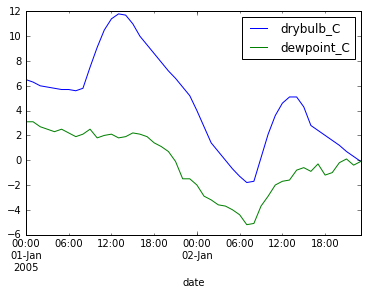

In [150]:
#epw_reader adapted from https://github.com/architecture-building-systems/CEAforArcGIS/blob/master/cea/utilities/epwreader.py

epw_labels = ['year', 'month', 'day', 'hour', 'minute', 'datasource', 'drybulb_C', 'dewpoint_C', 'relhum_percent',
                   'atmos_Pa', 'exthorrad_Whm2', 'extdirrad_Whm2', 'horirsky_Whm2', 'glohorrad_Whm2',
                   'dirnorrad_Whm2', 'difhorrad_Whm2', 'glohorillum_lux', 'dirnorillum_lux','difhorillum_lux',
                   'zenlum_lux', 'winddir_deg', 'windspd_ms', 'totskycvr_tenths', 'opaqskycvr_tenths', 'visibility_km',
                   'ceiling_hgt_m', 'presweathobs', 'presweathcodes', 'precip_wtr_mm', 'aerosol_opt_thousandths',
                   'snowdepth_cm', 'days_last_snow', 'Albedo', 'liq_precip_depth_mm', 'liq_precip_rate_Hour']

weather_path = 'C:\Users\Zghiru\Documents\GitHub\RC_BuildingSimulator\Justin_Semseter_Project\data\CH_ZH_original.epw'
    
def get_full_date(weather_path,month,day):
    year = pd.read_csv(weather_path, skiprows=8, header=None, names=epw_labels)['year']
    return pd.datetime(year[1],month,day)
    

def epw_reader(weather_path):
    start = get_full_date(weather_path,1,1)
    result = pd.read_csv(weather_path, skiprows=8, header=None, names=epw_labels).drop('datasource', axis=1)
    result['dayofyear'] = pd.date_range(start, periods=8760, freq='H').dayofyear  
    result['date'] = pd.date_range(start, periods=8760, freq='H')
    result['ratio_diffhout'] = result['difhorrad_Whm2']/result['glohorrad_Whm2']
    result['index'] = result.index
    return result


#extract column(s) from weather file for a range of days
def get_epw_data(start,end,field = []): 

    start += ' 00:00:00'
    end += ' 23:00:00'
    field.append('index')
    field.insert(0,'date')
    
    series = epw_reader(weather_path=weather_path)  
    series = series.set_index(['date'],drop=False)  
    series = series[start:end][field]
    series = series.set_index(['index']) 
    
    return series 


#Simple Plot
import matplotlib.pyplot as plt

start = '01/01/2005'
end =  '01/02/2005'

field = ['drybulb_C','dewpoint_C']

t = get_epw_data(start,end,field)
t = t.set_index(['date'])

t.plot()
plt.show()




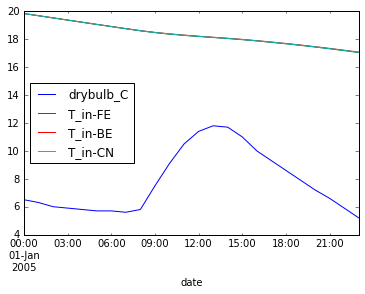

                     drybulb_C    T_in-FE    T_in-BE    T_in-CN
date                                                           
2005-01-01 00:00:00        6.5  19.844720  19.846486  19.845608
2005-01-01 01:00:00        6.3  19.688927  19.692444  19.690695
2005-01-01 02:00:00        6.0  19.531474  19.536742  19.534123
2005-01-01 03:00:00        5.9  19.374682  19.381673  19.378197
2005-01-01 04:00:00        5.8  19.218544  19.227231  19.222911
2005-01-01 05:00:00        5.7  19.063051  19.073407  19.068258
2005-01-01 06:00:00        5.7  18.909347  18.921333  18.915373
2005-01-01 07:00:00        5.6  18.756260  18.769851  18.763093
2005-01-01 08:00:00        5.8  18.607235  18.622366  18.614842
2005-01-01 09:00:00        7.5  18.479477  18.495889  18.487728
2005-01-01 10:00:00        9.1  18.371593  18.389045  18.380366
2005-01-01 11:00:00       10.5  18.281052  18.299335  18.290243
2005-01-01 12:00:00       11.4  18.201905  18.220880  18.211443
2005-01-01 13:00:00       11.8  18.12826

In [257]:
"""
Input data
Adapted from https://github.com/architecture-building-systems/RC_BuildingSimulator/blob/master/simulator/BuildingProperties.py
"""

class building(object): 
    def __init__(self, 
                 R_env = 42,   #resistance of envelope
                 Cm    = 2.07   #capacitance of envelope
                ):
        #Single Capacitance Model Parameters
        self.Cm=Cm #[kWh/K] Room Capacitance. Default based of Madsen2011
        self.R_env=R_env #[K/kW] Wall resistance to outside air. Default based off glass having a Uvalue of 1.978W/m2K, 12m2 facade glass
        
"""
main
"""

#Simulation parameters
start = '1/1/2005'
end = '1/1/2005'

#import data
temperatures = get_epw_data(start,end,['drybulb_C'])
T_out = temperatures['drybulb_C']
box = building(Cm = 2.07,R_env = 42)

#initialize conditions
duration = len(pd.date_range(start,end))*24
T_in_init = 20 #initial internal temperature
Data_Tin = []

#no heating or cooling, no internal gains, no external gains.

#differential equation parameters

dt = 1 #script needs to be adjusted because it currently truncates data from smaller timesteps to the equivalent length of 1dt

#Forward Euler discretization
def FE(T_in,dt): #takes initial internal temperature as input
    Data_Tin = []
    for i in range(0,duration):
        for j in range(0,int(1/dt)):
            T_in = ((T_out[i]-T_in)/(box.R_env*box.Cm))*dt + T_in
            Data_Tin.append(T_in)
    return Data_Tin

#Backward Euler discretization
def BE(T_in,dt): #takes initial internal temperature as input
    Data_Tin = []
    for i in range(0,duration):
        for j in range(0,int(1/dt)):
            T_in = ((T_out[i]*dt)+(box.R_env*box.Cm*T_in))/(box.R_env*box.Cm + dt)
            Data_Tin.append(T_in)
    return Data_Tin

#Crank Nicholson discretization
def CN(T_in,dt): #takes initial internal temperature as input
    Data_Tin = []
    for i in range(0,duration):     
        for j in range(0,int(1/dt)):
            T_in = ((2*T_out[i]*dt)+T_in*(2*box.R_env*box.Cm - dt))/(2*box.R_env*box.Cm +dt)
            Data_Tin.append(T_in)            
    return Data_Tin

"""
x= pd.Series(FE(T_in_init,dt))
x.plot()
plt.show
print x
"""


temperatures['T_in-FE'] = pd.Series(FE(T_in_init,dt))
temperatures['T_in-BE'] = pd.Series(BE(T_in_init,dt))
temperatures['T_in-CN'] = pd.Series(CN(T_in_init,dt))


temperatures = temperatures.set_index(['date'])

temperatures.plot()
plt.show()
print temperatures

T_out: External temperature in C extracted from an EPW weather file

T_in: Calculated internal temperature

R_env: Resistance of the envelope. Must be caluclated by hand and inputted into the Building class in BuildingProperties.py

R_infl: Equivalent resistance due to infiltration. This is calculated within BuildingProperties.py

R_vent: Equivalent resistance due to ventelation. A variable resistance calculated by the setVentelation method in within the Building class of BuildingProperties.py

Cm: Capacitance of the room. Must be caluclated by hand and inputted into the Building class in BuildingProperties.py

Q_Heat: Heat energy supplied or removed by the heater or cooler. This is determined through a controller based on the temperature set points

Q_rad: Heat energy to the sun. Hourly radiation data through the windows must be determined in advance and read through the read_transmittedR funtion of input_data.py

Q_gains: Internal heat gains of people. Determined through the occupancy profile which is read in through the read_occupancy function of input_data.py